In [313]:
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2


In [314]:
name = '001157'
img = '/Users/jinxuanchen/Files_Local/Point_image_fusion/kittidata/odometry/sequences/00/image_2/' + name + '.png'
binary = '/Users/jinxuanchen/Files_Local/Point_image_fusion/kittidata/odometry/sequences/00/velodyne/' + name + '.bin'
# txt = '/Users/jinxuanchen/Files_Local/Point_image_fusion/fusion_test/pcd/378/' + name + '.txt'
label_txt = '/Users/jinxuanchen/Files_Local/Point_image_fusion/kittidata/odometry/sequences/00/0_out/1_labels/' + name + '.txt'
# with open(txt,'r') as f:
#     calib = f.readlines()

In [315]:
P2 = np.matrix([[7.188560000000e+02,0.000000000000e+00,6.071928000000e+02,4.538225000000e+01],
               [0.000000000000e+00,7.188560000000e+02,1.852157000000e+02,-1.130887000000e-01],
               [0.000000000000e+00,0.000000000000e+00,1.000000000000e+00,3.779761000000e-03]])
P2

matrix([[ 7.188560e+02,  0.000000e+00,  6.071928e+02,  4.538225e+01],
        [ 0.000000e+00,  7.188560e+02,  1.852157e+02, -1.130887e-01],
        [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.779761e-03]])

In [316]:
Tr_velo_to_cam = np.matrix([[4.276802385584e-04,-9.999672484946e-01,-8.084491683471e-03,-1.198459927713e-02],
                            [-7.210626507497e-03,8.081198471645e-03,-9.999413164504e-01,-5.403984729748e-02],
                            [9.999738645903e-01,4.859485810390e-04,-7.206933692422e-03,-2.921968648686e-01]])
Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)
Tr_velo_to_cam

matrix([[ 4.27680239e-04, -9.99967248e-01, -8.08449168e-03,
         -1.19845993e-02],
        [-7.21062651e-03,  8.08119847e-03, -9.99941316e-01,
         -5.40398473e-02],
        [ 9.99973865e-01,  4.85948581e-04, -7.20693369e-03,
         -2.92196865e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])

In [317]:
# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
points = scan[:, 0:3] # lidar xyz (front, left, up)
points

array([[66.053734  ,  0.13996226,  2.4430685 ],
       [66.02354   ,  0.24293448,  2.4421186 ],
       [66.03214   ,  0.4508784 ,  2.4422197 ],
       ...,
       [ 3.855058  , -1.4492021 , -1.7852784 ],
       [ 3.8696675 , -1.441198  , -1.7902777 ],
       [ 3.8892546 , -1.434193  , -1.797278  ]], dtype=float32)

In [318]:
velo = np.insert(points,3,1,axis=1).T
velo

array([[66.053734  , 66.02354   , 66.03214   , ...,  3.855058  ,
         3.8696675 ,  3.8892546 ],
       [ 0.13996226,  0.24293448,  0.4508784 , ..., -1.4492021 ,
        -1.441198  , -1.434193  ],
       [ 2.4430685 ,  2.4421186 ,  2.4422197 , ..., -1.7852784 ,
        -1.7902777 , -1.797278  ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]], dtype=float32)

In [319]:
_,s = velo.shape
index  = np.arange(0,s).reshape(1,s)
index.shape

(1, 126290)

In [320]:
cam = P2 * Tr_velo_to_cam * velo
# cam1 = np.delete(cam,np.where(cam[2,:]<0)[1],axis=1)
cam1 = np.delete(cam, np.where(cam[2, :] < 0)[1], axis=1)
cam1.shape

(3, 63098)

In [321]:
index_cam1 = np.delete(index,np.where(cam[2,:]<0)[1],axis=1)
# index_cam1 = index
index_cam1.shape

(1, 63098)

In [302]:
# get u,v,z
cam1[:2] /= cam1[2,:]  # cam[:2] = cam[:2] /cam[2:]  uv = xy / z 
cam1

matrix([[606.27977308, 605.15293703, 602.87894847, ..., 911.14823061,
         908.31724756, 905.29955482],
        [152.70665392, 152.71361843, 152.73451902, ..., 524.78620596,
         524.39379096, 523.92589899],
        [ 65.74605136,  65.71591189,  65.72461795, ...,   3.57870224,
           3.59335136,   3.61299174]])

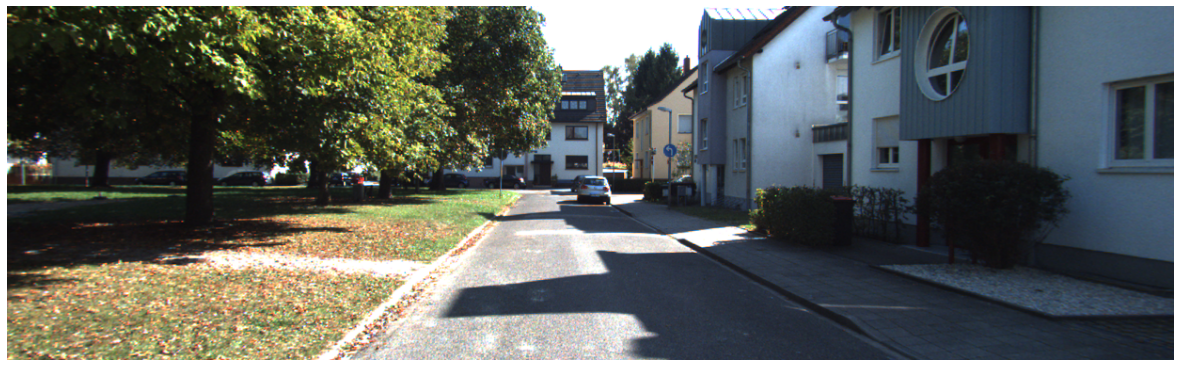

In [303]:
# do projection staff

plt.figure(figsize=(1242/72,375/72),dpi = 72, tight_layout=True)
png = mpimg.imread(img)
# png = cv2.imread(img)
# png = png[:,:,::-1]

IMG_H,IMG_W,_ = png.shape
# # restrict canvas in range
plt.axis('off')


plt.imshow(png)

In [304]:
# filter point out of canvas
u,v,z = cam1
u_out = np.logical_or(u<0, u>IMG_W)
v_out = np.logical_or(v<0, v>IMG_H)
outlier = np.logical_or(u_out, v_out)
cam2 = np.delete(cam1,np.where(outlier),axis=1)
cam2.shape

(3, 20589)

In [322]:
index_cam2 = np.delete(index_cam1,np.where(outlier),axis=1)
index_cam2

array([[    1,     2,     3, ..., 96052, 96053, 96054]])

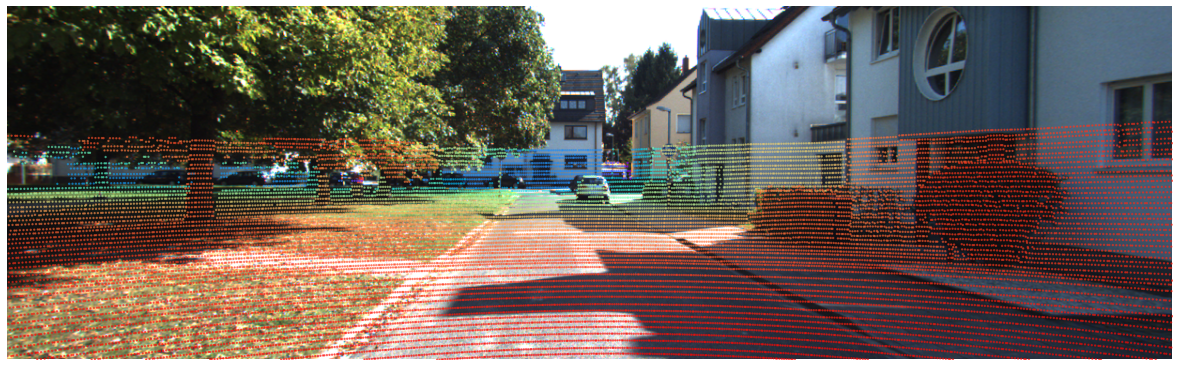

In [305]:
# generate color map from depth 
u,v,z = cam2

plt.figure(figsize=(1242/72,375/72),dpi = 72, tight_layout=True)
plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
plt.axis('off')
# # plt.axis([0,IMG_W,IMG_H,0])

plt.imshow(png)

fig = plt.gcf()
fig.set_size_inches(1242/72,375/72)

# plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)

# plt.savefig('/Users/jinxuanchen/Files_Local/Point_image_fusion/fusion_test/pcd/378/' + name + '_withpc.png', format='png', transparent=True, dpi=72, pad_inches = 0)

In [306]:
label = pd.read_csv(label_txt,header=None,sep=' ')
label

,0,1,2,3,4
0,34,0.567687,0.408245,0.010475,0.034575


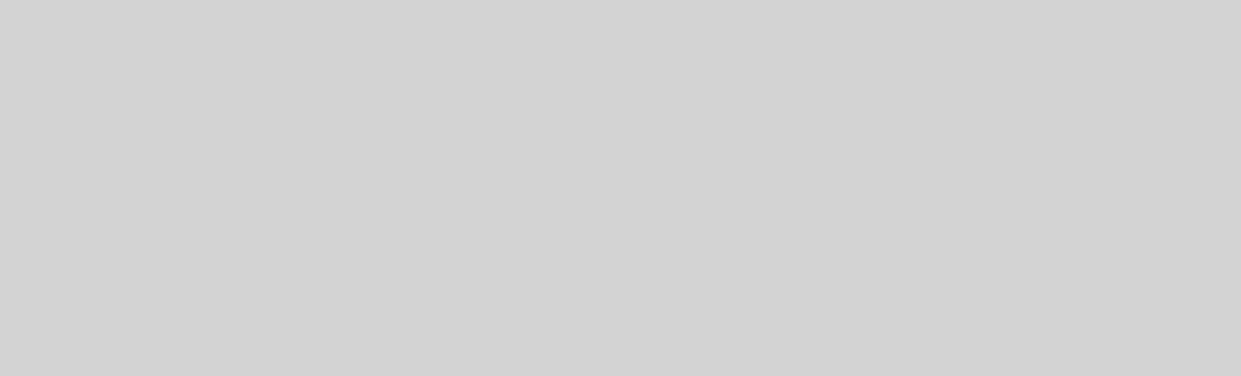

In [307]:
from PIL import Image
jpg = cv2.imread(img)
b_y, b_x, _ = jpg.shape
bg = Image.new("RGB",(b_x, b_y),(211,211,211))

bg

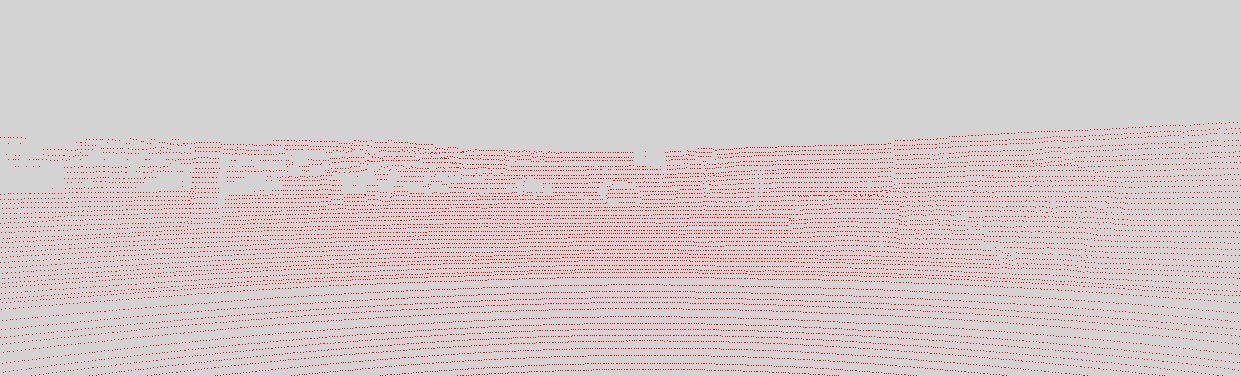

In [308]:
from PIL import ImageDraw
points = Image.new("RGB",(b_x, b_y),(211,211,211))
point = ImageDraw.ImageDraw(points)
_, i = u.shape

for i in range(0, i):
    x_2d = int(u[0, i])
    y_2d = int(v[0, i])
    point.point( (x_2d, y_2d), (255, 0, 0))

points


698


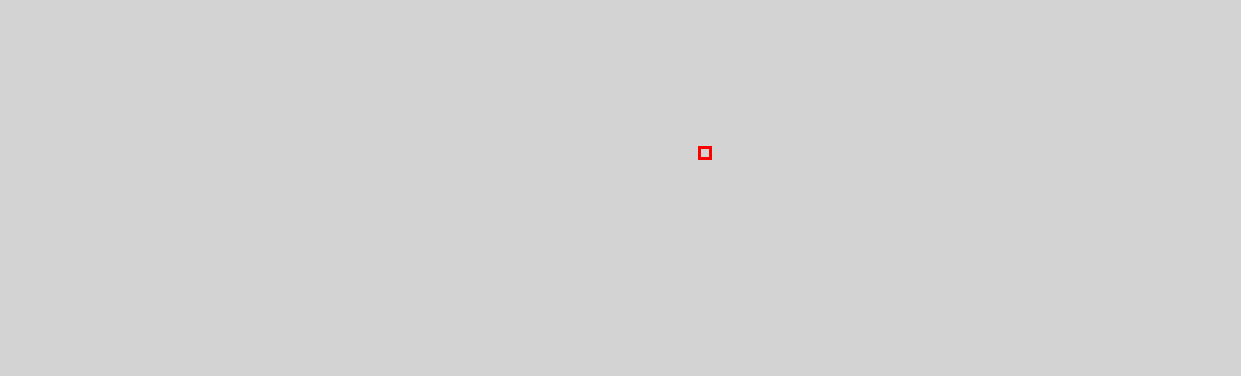

In [309]:
boxs = Image.new("RGB",(b_x, b_y),(211,211,211))
box = ImageDraw.ImageDraw(boxs)
for i in range(len(label[0])):
    box_lx = int(label[1][i]*1242-label[3][i]*1242/2)
    box_ly = int(label[2][i]*375-label[4][i]*375/2)
    box_rx = int(label[1][i]*1242+label[3][i]*1242/2)
    box_ry = int(label[2][i]*375+label[4][i]*375/2)
    print(box_lx)
    box.rectangle(((box_lx, box_ly), (box_rx, box_ry)),fill=None,outline=(255,0,0),width=3)

boxs

In [323]:
index_cam2[0,1]

2

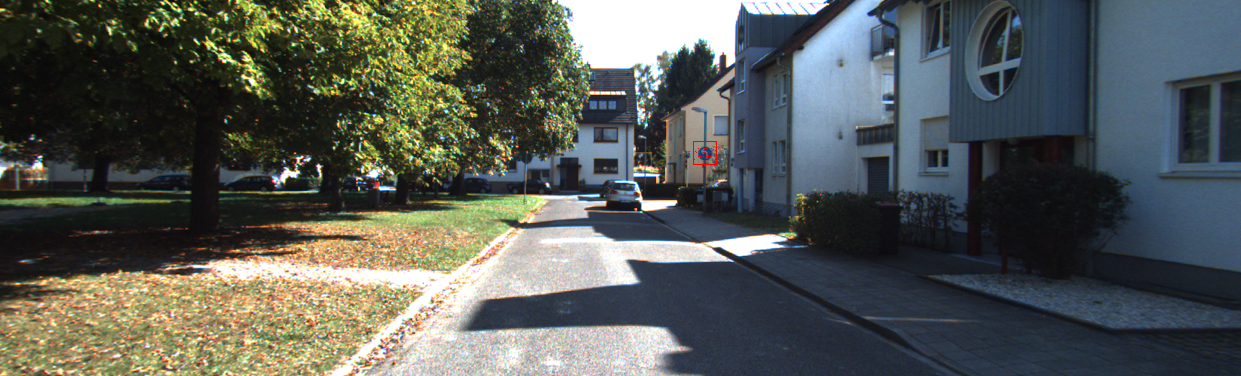

In [324]:
points_inbox = Image.open(img)
pinb = ImageDraw.ImageDraw(points_inbox)

enlarge = 5

_, j = u.shape
u_2d = []
v_2d = []
z_2d = []
index_inbox = []

for i in range(len(label[0])):
    box_lx = int(label[1][i]*1242-label[3][i]*1242/2 - enlarge)
    box_ly = int(label[2][i]*375-label[4][i]*375/2-enlarge)
    box_rx = int(label[1][i]*1242+label[3][i]*1242/2+enlarge)
    box_ry = int(label[2][i]*375+label[4][i]*375/2+enlarge)
    pinb.rectangle(((box_lx, box_ly), (box_rx, box_ry)),
                   fill=None, outline=(255, 0, 0), width=1)

    for j in range(0, j):
        if box_lx < int(u[0, j]) < box_rx and box_ly < int(v[0, j]) < box_ry:
            xinb_2d = (u[0, j])
            yinb_2d = (v[0, j])
            zinb_2d = (z[0, j])
            u_2d.append(xinb_2d)
            v_2d.append(yinb_2d)
            z_2d.append(zinb_2d)
            index_inbox.append(index_cam2[0, j])
            pinb.point((int(xinb_2d), int(yinb_2d)), (255, 0, 0))

points_inbox


In [82]:
index_inbox

[12187,
 12188,
 12189,
 12190,
 12191,
 12192,
 12193,
 12194,
 12195,
 12196,
 12197,
 12198,
 12199,
 12200,
 12201,
 12202,
 14063,
 14064,
 14065,
 14066,
 14067,
 14068,
 14069,
 14070,
 14071,
 14072,
 14073,
 14074,
 14075,
 14076,
 15988,
 15989,
 15990,
 15991,
 15992,
 15993,
 15994,
 15995,
 15996,
 15997,
 15998,
 15999,
 16000,
 16001,
 16002,
 16003,
 17957,
 17958,
 17959,
 17960,
 17961,
 17962,
 17963,
 17964,
 17965,
 17966,
 17967,
 17968,
 17969,
 17970,
 17971,
 17972,
 17973,
 17974,
 19963,
 19964,
 19965,
 19966,
 19967,
 19968,
 19969,
 19970,
 19971,
 19972,
 19973,
 19974,
 19975,
 19976,
 19977,
 19978,
 19979,
 21968,
 21969,
 21970,
 21971,
 21972,
 21973,
 21974,
 21975,
 21976,
 21977,
 21978,
 21979,
 21980,
 21981,
 21982,
 21983,
 23981,
 23982,
 23983,
 23984,
 23985,
 23986,
 23987,
 23988,
 23989,
 23990,
 23991,
 23992,
 23993,
 23994,
 23995,
 23996,
 23997,
 26037,
 26038,
 26039,
 26040,
 26041,
 26042,
 26043,
 26044,
 26045,
 26046,
 26047,


In [83]:
scan.shape

(121400, 4)

In [84]:
intensity = scan[:, 3:4].T
intensity

array([[0.  , 0.  , 0.07, ..., 0.37, 0.44, 0.  ]], dtype=float32)

In [86]:
x = []
y = []
z = []
inten = []

for i in index_inbox:
    x_t = velo[0,int(i)]
    y_t = velo[1,int(i)]
    z_t = velo[2,int(i)]
    i_t = intensity[0,int(i)]
    x.append(x_t)
    y.append(y_t)
    z.append(z_t)
    inten.append(i_t)
    
x = np.array(x)
y = np.array(y)
z = np.array(z)
inten = np.array(inten)


np.savetxt(point_out,np.vstack([x,y,z,inten]).T,fmt="%.8f")

In [778]:
import open3d as o3d
target_points = np.vstack([x,y,z,inten])


: 

In [ ]:
np.delete(target_points,np.where(target_points[0,:]<0),axis=1)